# **CICIDS2017 Dataset - Flow Level Data**

**1. Import Data**

In [ ]:
import csv
import pandas as pd

df = pd.read_csv("cicids2017_tmlcn.csv") # Flow level data
df.head()

,Timestamp,SrcPort,DstPort,FwdPktLenMax,FwdPktLenMin,FwdPktLenMean,Label
0,2017-05-07 09:30:00,49888,80,6,6,6.000000,BENIGN
1,2017-05-07 09:30:00,49944,443,202,0,69.375000,BENIGN
2,2017-05-07 09:30:00,49983,80,427,0,144.333333,BENIGN
3,2017-05-07 09:30:00,49990,80,6,6,6.000000,BENIGN
4,2017-05-07 09:30:00,50013,443,6,0,4.000000,BENIGN


In [ ]:
df['Label'].value_counts()

,count
Label,
Hulk,34587
BENIGN,19103
GoldenEye,1540
Slowhttptest,843
Slowloris,824


**2. Visualize attack timeline**

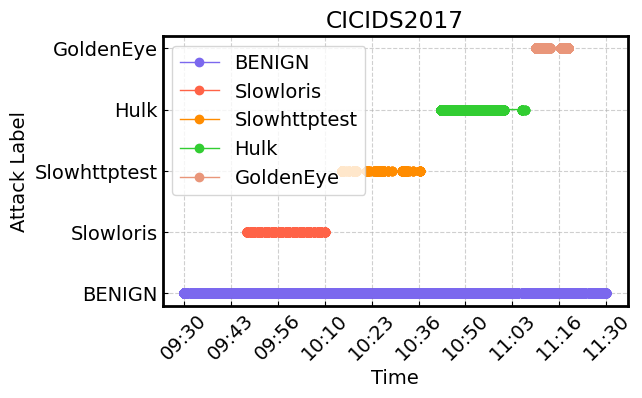

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert 'Timestamp' to datetime if it's not already in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df = df.sort_values('Timestamp')

# Get unique attack labels
attack_labels = df['Label'].unique()

# Define the colors you want to use
custom_colors = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']

# ['royalblue', 'tomato', 'limegreen', 'darksalmon', 'deepskyblue']

# Plotting
plt.figure(figsize=(6, 3.5), linewidth=4)

plt.rcParams.update({'font.size': 14})

# Plot instances for each class with custom colors
for label, color in zip(attack_labels, custom_colors):
    class_data = df[df['Label'] == label]
    plt.plot(class_data['Timestamp'], class_data['Label'], marker='o', linestyle='-', label=label, linewidth=1, color=color)

plt.xlabel('Time')
plt.ylabel('Attack Label')

# Calculate the positions of the x-axis ticks (showing only 10 ticks)
tick_count = 10

# Calculate the time range (min and max timestamps)
min_time = df['Timestamp'].min()
max_time = df['Timestamp'].max()

# Calculate evenly spaced timestamps for the ticks
tick_timestamps = np.linspace(min_time.timestamp(), max_time.timestamp(), tick_count)

# Convert tick_timestamps back to Timestamp objects
tick_timestamps = [pd.Timestamp.fromtimestamp(ts) for ts in tick_timestamps]

# Format the tick labels to display only the time (hour:minute:second)
tick_labels = [ts.strftime('%H:%M') for ts in tick_timestamps]

plt.xticks(tick_timestamps, tick_labels, rotation=45)
#plt.yticks(rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)


plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("CICIDS2017")
plt.show()

**3. Draw data distributiuoin**

In [ ]:
# Rename all attack types to 'Attack'
attack_types = ['Hulk', 'GoldenEye', 'Slowloris', 'Slowhttptest']  # List of attack types to rename
new_attack_name = 1  # New name for attack types

normal_name = 'BENIGN'
new_normal_name = 0

# Replace normal traffic with the new name
df['Label'] = df['Label'].replace(attack_types, new_attack_name)
df['Label'] = df['Label'].replace(normal_name, new_normal_name)

<ipython-input-4-66220477d9fc>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(normal_name, new_normal_name)


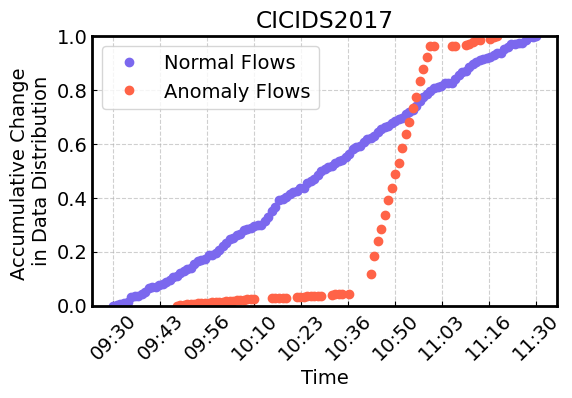

In [ ]:
# Convert 'Timestamp' to datetime if it's not already in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create a new DataFrame with cumulative sums for each class
cumulative_df = df.groupby(['Timestamp', 'Label']).sum().groupby(level=1).cumsum().reset_index()

# Sum SourcePort and DestinationPort values for each class
sum_df = cumulative_df.groupby('Label')[['SrcPort',	'DstPort',	'FwdPktLenMax',	'FwdPktLenMin',	'FwdPktLenMean']].sum().reset_index()

# Normalize the values for both classes
normalized_df = sum_df.copy()
normalized_df[['SrcPort',	'DstPort',	'FwdPktLenMax',	'FwdPktLenMin',	'FwdPktLenMean']] = normalized_df[['SrcPort',	'DstPort',	'FwdPktLenMax',	'FwdPktLenMin',	'FwdPktLenMean']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create a figure with border width 2 and line width 2
fig, ax = plt.subplots(figsize=(6, 3.5))

plt.rcParams.update({'font.size': 14})

#['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']

# Plot normalized accumulated values for combined SourcePort and DestinationPort over time for each class
for label, color in zip(normalized_df['Label'], ['mediumslateblue', 'tomato']):
    label_df = cumulative_df[cumulative_df['Label'] == label]
    combined_values = label_df['SrcPort'] +	label_df['DstPort'] +	label_df['FwdPktLenMax'] +	label_df['FwdPktLenMin'] +	label_df['FwdPktLenMean']
    normalized_combined_values = (combined_values - combined_values.min()) / (combined_values.max() - combined_values.min())



    # Set legend labels for Class 0 and Class 1
    legend_label = 'Normal Flows' if label == 0 else 'Anomaly Flows'

    ax.plot(label_df['Timestamp'], normalized_combined_values, label=legend_label, color=color, linewidth=2, marker='o', linestyle='')

ax.set_xlabel('Time')
ax.set_ylabel('Accumulative Change \nin Data Distribution')

# Set y-axis limits from 0 to 1
ax.set_ylim(0, 1)


tick_labels = [ts.strftime('%H:%M') for ts in tick_timestamps]
plt.xticks(tick_timestamps, tick_labels, rotation=45)

# Add legend
ax.legend()

ax.grid(True, linestyle='--', alpha=0.6)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)


# Show the plot
plt.title("CICIDS2017")
plt.show()

**4. Preprocessing for model training**

In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.5 MB/s eta 0:00:00


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
columns_to_drop = ['Timestamp']
df = df.drop(columns=columns_to_drop)

In [ ]:
# Preprocessing
X = df.iloc[:, df.columns != 'Label'].values  # Convert to NumPy array
y = df[['Label']].to_numpy()

# Label encoding
le = preprocessing.LabelEncoder().fit(y)
y = le.transform(y)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


**Adversarial Testing**

**5. Draw model results with original data**

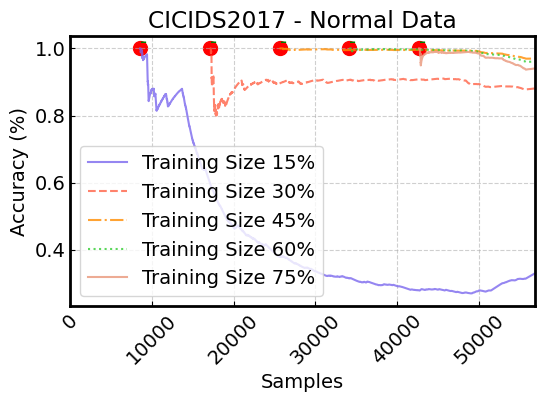

In [ ]:
# Accuracy over differnet training set

# Select a few key training sizes to plot
training_sizes = [15, 30, 45, 60, 75]

plt.figure(figsize=(6, 3.5))
plt.clf()
plt.rcParams.update({'font.size': 14})

# Use a distinct color palette and line styles
#color_palette = ['blue', 'green', 'red', 'purple', 'orange']

color_palette = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']

line_styles = ['-', '--', '-.', ':', '-']

for idx, training_size in enumerate(training_sizes):
    actual_training_size = int(len(X) * training_size / 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=actual_training_size, random_state=42, shuffle=False)

    # Original data prediction
    clf = DecisionTreeClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)




    acc = []
    acc_sum = 0
    for i in range(0, len(y_test)):
        if y_test[i] == y_pred[i]:
            acc_sum = acc_sum + 1
        accuracy_i = acc_sum / (i + 1)
        acc.append(accuracy_i)

    # Calculate the index where the test set starts
    test_start_index = len(X_train)

    # Plot the accuracy change over time and mark the test set start
    plt.plot(range(test_start_index, len(X_test) + test_start_index), acc[test_start_index - len(X_train):], label=f'Training Size {training_size}%', color=color_palette[idx], linestyle=line_styles[idx], alpha=0.8)

    plt.scatter(test_start_index, acc[0], s=100, c='r', marker='o')
    plt.text(test_start_index, acc[0] + 0.0005, '-', c='g')

plt.legend(loc='lower left')
#plt.title('Accuracy Change over Intrusion Detection Dataset (CICIDS2017)', fontsize=15, fontweight='bold')
plt.xlabel('Samples')
plt.ylabel('Accuracy (%)')

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)

# ax.spines['bottom'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)


# Set x-axis limits based on test set size
plt.xlim(0, len(X))

plt.grid(True, linestyle='--', alpha=0.6)
plt.title("CICIDS2017 - Normal Data")
plt.show()

**6. Draw model results with adversarial data**

Decision tree attack:   0%|          | 0/48363 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/39828 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/31294 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/22759 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/14225 [00:00<?, ?it/s]

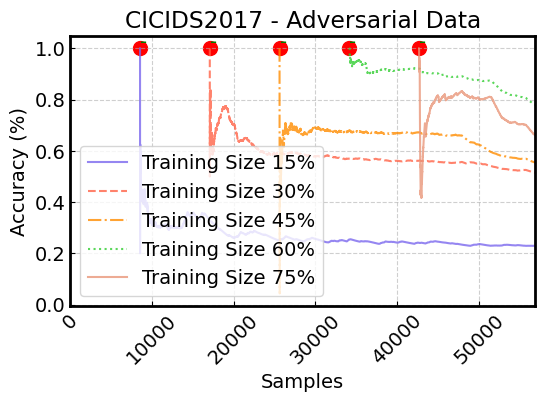

In [ ]:
# Accuracy for adversarial examples over different training set sizes

# Select a few key training sizes to plot
training_sizes = [15, 30, 45, 60, 75]

plt.figure(figsize=(6, 3.5))
plt.clf()
plt.rcParams.update({'font.size': 14})

# Use a distinct color palette and line styles
color_palette = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']
line_styles = ['-', '--', '-.', ':', '-']

for idx, training_size in enumerate(training_sizes):
    actual_training_size = int(len(X) * training_size / 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=actual_training_size, random_state=42, shuffle=False)

    # Train the classifier on original data
    clf = DecisionTreeClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)

    # Attack - Generate adversarial examples
    clf_art = SklearnClassifier(clf)
    attack = DecisionTreeAttack(clf_art, offset=0.00001)
    try:
        adv = attack.generate(X_test)
    except Exception as e:
        print(f"Error generating adversarial examples: {e}")
        continue  # Skip this iteration or handle as needed

    # Predict adversarial examples and calculate accuracy
    y_pred_adv = clf.predict(adv)
    accuracy_adv = accuracy_score(y_test, y_pred_adv)

    acc = []
    acc_sum = 0
    for i in range(0, len(y_test)):
        if y_test[i] == y_pred_adv[i]:
            acc_sum = acc_sum + 1
        accuracy_i = acc_sum / (i + 1)
        acc.append(accuracy_i)

    # Calculate the index where the test set starts
    test_start_index = len(X_train)

    # Plot the adversarial accuracy change over time
    plt.plot(range(test_start_index, len(X_test) + test_start_index), acc[test_start_index - len(X_train):],
             label=f'Training Size {training_size}%', color=color_palette[idx], linestyle=line_styles[idx], alpha=0.8)

    plt.scatter(test_start_index, acc[0], s=100, c='r', marker='o')
    plt.text(test_start_index, acc[0] + 0.0005, '-', c='g')

plt.legend(loc='lower left')
plt.xlabel('Samples')
plt.ylabel('Accuracy (%)')

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)

# Set x-axis limits based on test set size
plt.xlim(0, len(X))

plt.grid(True, linestyle='--', alpha=0.6)
plt.title("CICIDS2017 - Adversarial Data")
plt.show()


**General Adversarial Method**

In [ ]:
# Preprocessing
X = df.iloc[:, df.columns != 'Label'].values  # Convert to NumPy array
y = df[['Label']].to_numpy()

# Label encoding
le = preprocessing.LabelEncoder().fit(y)
y = le.transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=0, shuffle=True)

# DTC Classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=0) # max_depth=10
clf.fit(X_train, y_train)

clf_art = SklearnClassifier(clf)

# Select 50 entries from index 10000 to 10050 for testing
# X_test = X[10000:11000]
# y_test = y[10000:11000]


# Make predictions on the original (non-adversarial) data
y_pred_original = clf.predict(X_test)

print("clf features importance")
feature_importances_original = clf.feature_importances_
print(feature_importances_original)

# Evaluate the model performance on the original data
accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original, average='weighted')
recall_original = recall_score(y_test, y_pred_original, average='weighted')
f1_original = f1_score(y_test, y_pred_original, average='weighted')

print(f"Original Model Performance:")
print(f"Accuracy: {accuracy_original:.4f}")
print(f"Precision: {precision_original:.4f}")
print(f"Recall: {recall_original:.4f}")
print(f"F1 Score: {f1_original:.4f}")

# Attack - Generate adversarial examples
attack = DecisionTreeAttack(clf_art, offset=0.001)
adv = attack.generate(X_test)

# Make predictions on the adversarial data
y_pred_adv = clf.predict(adv)

print("adv features importance")
feature_importances_adv = clf.feature_importances_
print(feature_importances_adv)

# Evaluate the model performance on the adversarial data
accuracy_adv = accuracy_score(y_test, y_pred_adv)
precision_adv = precision_score(y_test, y_pred_adv, average='weighted')
recall_adv = recall_score(y_test, y_pred_adv, average='weighted')
f1_adv = f1_score(y_test, y_pred_adv, average='weighted')

print(f"\nAdversarial Model Performance - degraded performance due to adversarial (modified) samples:")
print(f"Accuracy: {accuracy_adv:.4f}")
print(f"Precision: {precision_adv:.4f}")
print(f"Recall: {recall_adv:.4f}")
print(f"F1 Score: {f1_adv:.4f}")

# print("\n Original data prediction    : ", y_pred_original)
# print("\n Adversarial data prediction : ", y_pred_adv)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


clf features importance
[0.04001567 0.41556827 0.07987107 0.43976384 0.02478115]
Original Model Performance:
Accuracy: 0.9842
Precision: 0.9842
Recall: 0.9842
F1 Score: 0.9841


Decision tree attack:   0%|          | 0/17070 [00:00<?, ?it/s]

adv features importance
[0.04001567 0.41556827 0.07987107 0.43976384 0.02478115]

Adversarial Model Performance - degraded performance due to adversarial (modified) samples:
Accuracy: 0.0158
Precision: 0.0145
Recall: 0.0158
F1 Score: 0.0134


**Change in Data Distribution before and after adversarial**

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Convert to DataFrame for better handling
# feature_names = df.columns[df.columns != 'Label']
# df_original = pd.DataFrame(X_test, columns=feature_names)
# df_adv = pd.DataFrame(adv, columns=feature_names)

# # Add Labels (originally predicted, before attack)
# df_original['Label'] = y_pred_original  # Labels BEFORE adversarial attack
# df_adv['Label'] = y_pred_adv            # Labels AFTER adversarial attack

# # Separate data
# df_benign = df_original[df_original['Label'] == 0]  # Benign samples
# df_attack = df_original[df_original['Label'] == 1]  # Original attack samples
# df_adv_attack = df_adv[df_adv['Label'] == 0]        # Adversarially modified attack samples

# # Set up subplots: One for each feature, 3 distributions in each subplot
# num_features = len(feature_names)
# fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(5, num_features * 3))

# for i, feature in enumerate(feature_names):
#     ax = axes[i]  # Each subplot for each feature

#     # Plot all distributions: Benign, Original Attack, and Adversarial Attack
#     sns.kdeplot(df_benign[feature], label='Benign', color='royalblue', ax=ax, fill=True, alpha=0.5)
#     sns.kdeplot(df_attack[feature], label='Original Attack', color='crimson', ax=ax, fill=True, alpha=0.5)
#     sns.kdeplot(df_adv_attack[feature], label='Adversarial Attack', color='limegreen', ax=ax, fill=True, alpha=0.5)

#     # Title and legend
#     ax.set_title(f'Distribution for {feature}')
#     ax.legend()

# plt.tight_layout()
# plt.show()


**7. Get the features importance over segments**

Segment ID: 1
Accuracy: 0.6442382057231245
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 2
Accuracy: 0.6003480278422274
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 3
Accuracy: 0.938708430007734
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 4
Accuracy: 0.9675174013921114
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 5
Accuracy: 0.9684841453982985
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 6
Accuracy: 0.9766047950502706
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 7
Accuracy: 0.9738979118329466
Selected Features: ['SrcPort', 'DstPort', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean']
Segment ID: 8
Accuracy: 0.9365815931941222
Selected Features: [

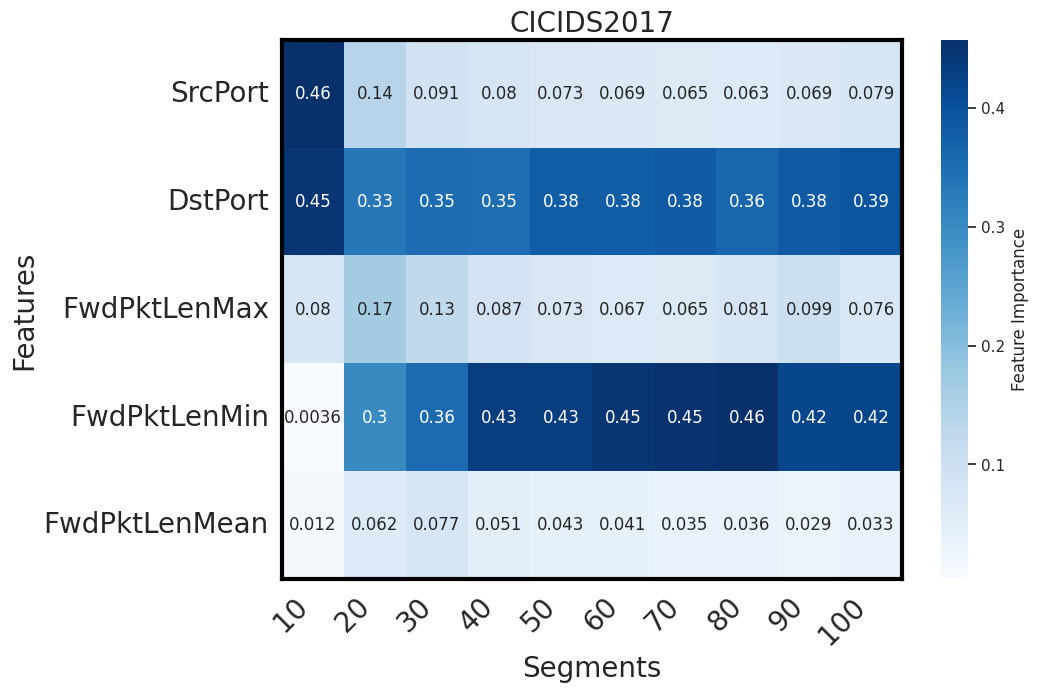

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a Pandas DataFrame named "dfff" with a "Label" column as the target variable
# df = dataset.csv

# Split your data into 12 segments
n_segments = 11
segment_size = len(df) // n_segments

# Initialize lists to store true and predicted labels for confusion matrices
all_y_true = []
all_y_pred = []

# Initialize a list to store feature importances for each iteration
all_feature_importances = []

# Initialize a SelectKBest feature selector to select the top 5 features
selector = SelectKBest(score_func=f_classif, k=5)

for segment in range(1, n_segments):  # Start from the second segment
    # Accumulate data until the current segment
    train_start = 0
    train_end = (segment + 1) * segment_size
    X_train = df.iloc[train_start:train_end].drop(columns=['Label'])
    y_train = df.iloc[train_start:train_end]['Label']

    # Train the model on the accumulated training data
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Split the data into testing and validation segments
    test_start = (segment + 1) * segment_size
    test_end = (segment + 2) * segment_size
    X_test = df.iloc[test_start:test_end].drop(columns=['Label'])
    y_test = df.iloc[test_start:test_end]['Label']

    # Make predictions on the test segment
    y_pred = clf.predict(X_test)

    # Calculate accuracy for this segment
    accuracy = accuracy_score(y_test, y_pred)
    print("Segment ID:", segment)
    print("Accuracy:", accuracy)

    # Append true and predicted labels to the lists
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calculate feature importances for this iteration
    segment_feature_importances = clf.feature_importances_
    all_feature_importances.append(segment_feature_importances)

    # Perform feature selection for this segment
    selector.fit(X_train, y_train)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_train.columns[selected_feature_indices]
    print("Selected Features:", selected_feature_names.tolist())

# Calculate and print the mean accuracy across all segments
mean_accuracy = accuracy_score(all_y_true, all_y_pred)
print("Mean Accuracy Across All Segments:", mean_accuracy)

# Prepare data for the heatmap
feature_labels = X_train.columns
feature_importances = np.array(all_feature_importances).T  # Transpose for correct alignment

# Set Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# Create a heatmap of feature importances with the specified color palette
heatmap = sns.heatmap(feature_importances, annot=True, cmap='Blues', xticklabels=[str(i*10) for i in range(1, n_segments)], yticklabels=feature_labels, cbar_kws={'label': 'Feature Importance'})
plt.xlabel("Segments", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xticks(rotation=45, ha='right')  # Align x-axis labels to the right
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Set the font size of x-axis and y-axis tick labels
heatmap.tick_params(axis='both', labelsize=20)

# Access the Axes object from the heatmap
ax = heatmap.axes

# Set spines width and color
for spine in ax.spines.values():
    spine.set_linewidth(3)  # Set the desired border width
    spine.set_color('black')  # Set the desired border color
    spine.set_visible(True)  # Ensure the spines are visible

# Set the background color of the entire plot
ax.set_facecolor('none')

plt.title("CICIDS2017", fontsize=20)
plt.show()
plt.show()